In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Improvements

- made softmax more uniform (by minimizing W2 and b2 initialization)
- prevented tanh from saturating (by minimizing W1 and b1 initalization)
- added batch norm layers which will work better for deeper nn (by normalizing each batch using -mean/std)

generally want initializations to have abs value close to 0 to start with

In [48]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0
bnbias = torch.zeros((1, n_hidden)) * 0
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.2958
  10000/ 200000: 2.1144
  20000/ 200000: 2.6239
  30000/ 200000: 2.0770
  40000/ 200000: 2.3257
  50000/ 200000: 1.8853
  60000/ 200000: 2.2403
  70000/ 200000: 2.3523
  80000/ 200000: 2.4743
  90000/ 200000: 2.1204
 100000/ 200000: 2.3244
 110000/ 200000: 2.4645
 120000/ 200000: 1.7122
 130000/ 200000: 2.1260
 140000/ 200000: 2.3675
 150000/ 200000: 2.1011
 160000/ 200000: 2.0507
 170000/ 200000: 2.3557
 180000/ 200000: 2.3214
 190000/ 200000: 2.1359


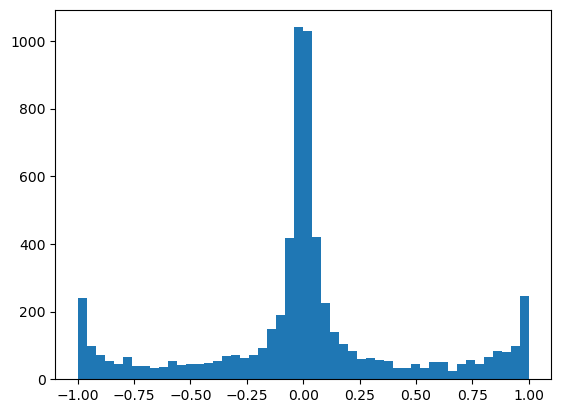

In [50]:
# hidden activations are very extreme => flat on a tanh, slow learning
# if you squash all the initializations it looks much better!
plt.hist(h.view(-1).tolist(),50);

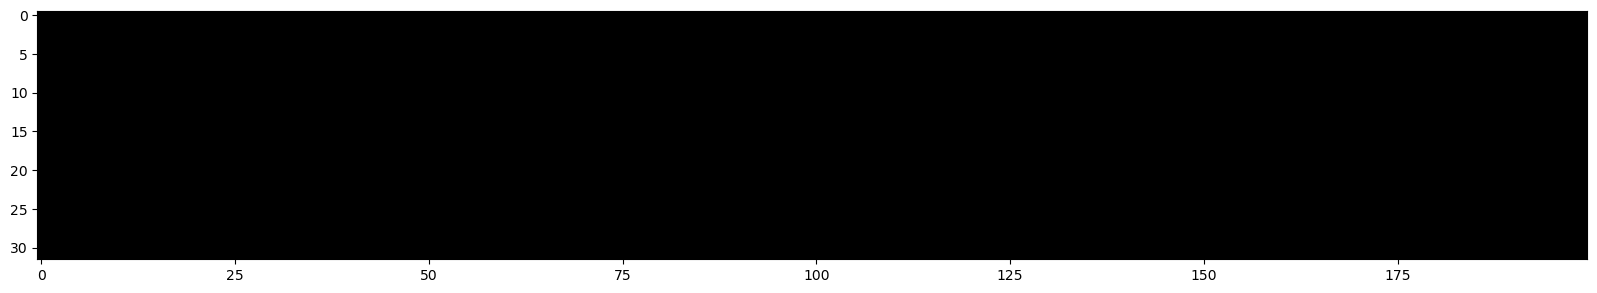

In [31]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [36]:
# don't need this if using running bn mean and std
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067725896835327
val 2.107140302658081


### Kaiming init

`std = gain/sqrt(fan_in)`

Think of fan_in as the input n, and when you multiply samples you have to divide the stdev by sqrt(n). Different activation fxns have different gains depending on how is squashes/clamps the preactivations.

In [35]:
torch.randn(100000).std(0)
# torch.rand has std of ~0.28 since it is uniform between 1 to 0

tensor(1.0001)

Improvements for initializations: 1) residual connections, 2) normalization layers (bn, ln), 3) optimizers (Adam, RMSprop)

## Exercises

- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

Value of tanh is 0 since all inputs are 0, so in forward pass all the activations will be the same. In backward pass, the grad of tanh = (1 - t**2) * out.grad = 1\*out.grad will just be out.grad => all the neurons will have the same grad updates and take on the same values. This means that it is no different than having just 1 node per hidden layer, called the "Symmetry problem".

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

After optimizing gamma and beta, you can multiply all the weights by bngain aka gamma and add bnbias aka beta to all the biases of W2 and B2 to stabilize during inference.